### Imports

In [520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## preprocessing - NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

## workflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier

## metrics
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, 
                            ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score, classification_report, RocCurveDisplay)

In [2]:
%run 00_Workflow_Functions.ipynb import na_only, make_model

In [3]:
# recovering train and test data
%store -r stored_data

In [4]:
X_train = stored_data['X_train']
X_test = stored_data['X_test']

y_train_encoded = stored_data['y_train_encoded']
y_test_encoded = stored_data['y_test_encoded']

### Vectorizing Data

For our first model iteration, we will do a simple vectorization of text data. We will then evaluate our model performance and further engineer our text features.

In [5]:
cvec = CountVectorizer()

In [6]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).A, columns=cvec.get_feature_names_out())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).A, columns=cvec.get_feature_names_out())
X_train_cvec.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(X_train_cvec.shape, X_test_cvec.shape)

(1857, 12373) (619, 12373)


In [78]:
cvec_top_20 = X_train_cvec.sum().sort_values(ascending=False)[:20]
cvec_top_20

the     5813
to      5415
and     4540
you     4057
it      3075
of      2726
in      2164
that    2072
for     1982
is      1788
your    1763
this    1450
if      1327
on      1295
my      1281
or      1280
can     1243
have    1223
with    1180
but     1125
dtype: int64

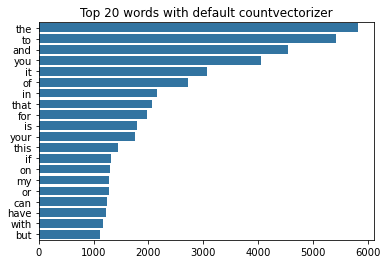

In [93]:
sns.barplot(y=list(cvec_top_20.index), x=cvec_top_20.values, orient='h', color='tab:blue')
plt.title("Top 20 words with default countvectorizer");

There are a vast amount of stop words (nouns and pronouns) in our submission data. Let's try and cut that down using the default stopwords list in the count vectorizer class.

In [94]:
cvec2 = CountVectorizer(stop_words='english')

In [95]:
X_train_cvec2 = pd.DataFrame(cvec2.fit_transform(X_train).A, columns=cvec2.get_feature_names_out())
X_test_cvec2 = pd.DataFrame(cvec2.transform(X_test).A, columns=cvec2.get_feature_names_out())
X_train_cvec2.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
print(X_train_cvec2.shape, X_test_cvec2.shape)

(1857, 12084) (619, 12084)


In [97]:
X_train_cvec2.shape[1] - X_train_cvec.shape[1]

-289

We have 289 less columns in our vectorization without stop words.

In [98]:
cvec2_top_20 = X_train_cvec2.sum().sort_values(ascending=False)[:20]
cvec2_top_20

just      747
don       660
like      631
time      579
people    487
know      412
make      399
ve        360
work      343
want      341
way       321
use       315
need      296
life      268
really    257
help      246
things    246
day       233
feel      227
good      219
dtype: int64

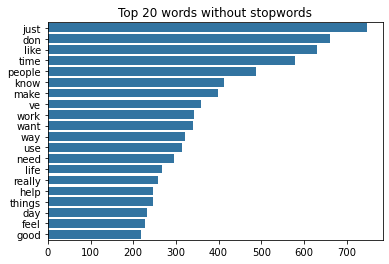

In [99]:
sns.barplot(y=list(cvec2_top_20.index), x=cvec2_top_20.values, orient='h', color='tab:blue')
plt.title("Top 20 words without stopwords");

Stop words have been cut down; however, the frequency of the new words are a lot less than the frequency of stop words.
We also have a lot more adverbs in hour list.

Let's now tokenize our words using uni- and bigrams, and see what patterns emerge.

In [126]:
cvec3 = CountVectorizer(stop_words='english', ngram_range=(2, 2))

In [127]:
X_train_cvec3 = pd.DataFrame(cvec3.fit_transform(X_train).A, columns=cvec3.get_feature_names_out())
X_test_cvec3 = pd.DataFrame(cvec3.transform(X_test).A, columns=cvec3.get_feature_names_out())
X_train_cvec3.head(5)

,00 apy,00 didn,00 lowest,00 mashing,00 pair,000 100,000 11,000 calories,000 doubled,000 dual,...,還是因為距離 還是因為每個人各自的苦衷,還會陷入愛情嗎 即便再來一次,那些懵懂而青澀的過往 卻會是我們一生的珍藏,那些沒有結果的感情 結局不完美,那個你本以為忘記的人 就會像蜜蜂蟄了心,都成眷屬 人生有得失,都會實現 不是每一對戀人,都會結果 不是每一次心願,都有可能改變你的生活 主播,餘生 希望彼此都能把對方放下
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [129]:
X_train_cvec3.shape[1] - X_train_cvec.shape[1]

53141

We have 65,225 more columns by tokenizing our words into uni- and bigrams.

In [130]:
cvec3_top_20 = X_train_cvec3.sum().sort_values(ascending=False)[:20]
cvec3_top_20

https www        79
make sure        75
don know         69
don want         65
feel like        56
amp x200b        52
don need         26
long time        26
ice cream        25
things like      25
credit card      24
just like        22
tiger19 tw       21
https tiger19    21
best way         21
years ago        20
lot people       20
let know         19
just need        19
don let          18
dtype: int64

A fair amount of bigrams appear to include the word "don" which seems to be a typo of the word "don't".

Let's try to capture words that fall more inbetween, and drop the stop words. Ideally, we will get more substance in our tokens.

In [222]:
cvec4 = CountVectorizer(stop_words='english', min_df=2, max_df=.05)

In [223]:
X_train_cvec4 = pd.DataFrame(cvec4.fit_transform(X_train).A, columns=cvec4.get_feature_names_out())
X_test_cvec4 = pd.DataFrame(cvec4.transform(X_test).A, columns=cvec4.get_feature_names_out())
X_train_cvec4.head(5)

,00,000,03,04,09,10,100,1000,10mm,10pm,...,youtube,youtubers,yr,ysk,yt,zero,zip,zipper,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [225]:
X_train_cvec4.shape[1] - X_train_cvec.shape[1]

-6678

We have 6341 less columns in our vectorization that removes all tokens that appear only once.

In [226]:
cvec4_top_20 = X_train_cvec4.sum().sort_values(ascending=False)[:20]
cvec4_top_20

amp         210
com         160
job         152
car         139
phone       138
food        131
didn        117
tell        115
friends     114
buy         112
year        109
home        109
place       108
days        108
away        108
hard        107
thought     106
actually    103
makes       102
family      102
dtype: int64

Both train and test splits have been successfully vectorized. We have generated 12,373 unique strings of characters to use as features.

----

In [247]:
tf = TfidfVectorizer()

In [248]:
X_train_tf = pd.DataFrame(tf.fit_transform(X_train).A, columns=tf.get_feature_names_out())
X_test_tf = pd.DataFrame(tf.transform(X_test).A, columns=tf.get_feature_names_out())
X_train_tf.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
print(X_train_tf.shape, X_test_tf.shape)

(1857, 12373) (619, 12373)


In [250]:
X_train_tf.shape[1] - X_train_cvec.shape[1]

0

No difference in columns.

In [251]:
tf_top_20 = X_train_tf.sum().sort_values(ascending=False)[:20]
tf_top_20

the     134.358644
to      126.538852
you     119.742349
and     107.773955
it       92.904469
of       76.170678
in       66.430528
your     65.054745
that     63.961475
for      63.268461
is       58.390111
my       52.660376
this     52.333168
if       49.337244
or       49.092183
they     48.041709
can      47.644796
on       47.471241
have     47.353845
be       43.878182
dtype: float64

In [261]:
tf2 = TfidfVectorizer(stop_words='english')

In [262]:
X_train_tf2 = pd.DataFrame(tf2.fit_transform(X_train).A, columns=tf2.get_feature_names_out())
X_test_tf2 = pd.DataFrame(tf2.transform(X_test).A, columns=tf2.get_feature_names_out())
X_train_tf2.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
print(X_train_tf2.shape, X_test_tf2.shape)

(1857, 12084) (619, 12084)


In [264]:
X_train_tf2.shape[1] - X_train_cvec.shape[1]

-289

No difference in columns.

In [265]:
tf2_top_20 = X_train_tf2.sum().sort_values(ascending=False)[:20]
tf2_top_20

just      40.954925
don       39.303518
time      35.072493
like      33.896326
people    30.334257
know      28.402043
make      25.380831
ve        24.500534
way       23.576415
work      22.752416
use       22.512086
need      22.328425
want      21.779673
life      20.344747
ll        20.041487
help      19.270469
things    19.059382
day       18.570899
really    17.310903
better    16.670762
dtype: float64

In [269]:
tf3 = TfidfVectorizer(min_df=2, max_df=.05)

In [270]:
X_train_tf3 = pd.DataFrame(tf3.fit_transform(X_train).A, columns=tf3.get_feature_names_out())
X_test_tf3 = pd.DataFrame(tf3.transform(X_test).A, columns=tf3.get_feature_names_out())
X_train_tf3.head(5)

,00,000,03,04,09,10,100,1000,10mm,10pm,...,youtube,youtubers,yr,ysk,yt,zero,zip,zipper,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018179,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [271]:
print(X_train_tf3.shape, X_test_tf3.shape)

(1857, 5849) (619, 5849)


In [272]:
X_train_tf3.shape[1] - X_train_cvec.shape[1]

-6524

No difference in columns.

In [273]:
tf3_top_20 = X_train_tf3.sum().sort_values(ascending=False)[:20]
tf3_top_20

he         15.618677
amp        15.152735
car        14.741961
phone      14.189532
her        13.867897
job        13.575588
food       13.565272
she        12.454210
com        12.298219
else       11.787635
tell       11.560581
easy       11.390016
days       11.296299
makes      11.206555
why        11.009124
thought    10.993230
next       10.724250
buy        10.718025
friends    10.627139
our        10.619609
dtype: float64

In [281]:
tf4 = TfidfVectorizer(min_df=15, max_df=.05)

In [291]:
X_train_tf4 = pd.DataFrame(tf4.fit_transform(X_train).A, columns=tf4.get_feature_names_out())
X_test_tf4 = pd.DataFrame(tf4.transform(X_test).A, columns=tf4.get_feature_names_out())
X_train_tf4.head(5)

,10,100,12,15,20,25,30,50,able,above,...,writing,wrong,www,x200b,year,yes,yet,young,youtube,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.27878,0.0,0.0,0.0,0.149714,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038148,...,0.081017,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.040509
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [283]:
print(X_train_tf4.shape, X_test_tf4.shape)

(1857, 863) (619, 863)


In [284]:
X_train_tf4.shape[1] - X_train_cvec.shape[1]

-11510

No difference in columns.

In [285]:
tf4_top_20 = X_train_tf4.sum().sort_values(ascending=False)[:20]
tf4_top_20

he         22.873055
car        22.859693
amp        22.361545
food       21.083131
phone      20.869995
com        20.155508
job        19.964443
her        19.318759
easy       18.327044
tell       18.104376
makes      17.768162
she        17.438670
else       17.398295
buy        17.185012
why        16.733988
days       16.692649
next       16.552489
thought    16.506108
two        16.405383
hard       16.388941
dtype: float64

In [297]:
tf5 = TfidfVectorizer(min_df=15, max_df=.05, ngram_range=(2, 2))

In [298]:
X_train_tf5 = pd.DataFrame(tf5.fit_transform(X_train).A, columns=tf5.get_feature_names_out())
X_test_tf5 = pd.DataFrame(tf5.transform(X_test).A, columns=tf5.get_feature_names_out())
X_train_tf5.head(5)

,able to,about how,about it,about the,about this,about what,after the,all my,all of,all you,...,you would,you you,your body,your car,your friends,your life,your mind,your own,your phone,your time
0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.1638,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.067396,0.068213,0.0,0.07389,0.0,0.0,0.0,0.0,...,0.07389,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [299]:
print(X_train_tf5.shape, X_test_tf5.shape)

(1857, 758) (619, 758)


In [300]:
X_train_tf5.shape[1] - X_train_cvec.shape[1]

-11615

No difference in columns.

In [301]:
tf5_top_20 = X_train_tf5.sum().sort_values(ascending=False)[:20]
tf5_top_20

you ll       24.111328
from the     21.767009
way to       21.294578
how to       21.213515
it will      21.071963
https www    20.078578
they re      19.447098
you will     19.194376
the time     18.674134
you to       18.444543
you need     18.297080
at least     18.058391
if it        17.878540
going to     17.767393
of my        17.702946
you want     17.591376
ve been      17.305209
on my        17.287241
the first    17.192915
able to      16.728176
dtype: float64

----

In [303]:
## adding lemmatization
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(word) for word in word_tokenize(doc)]

In [349]:
lt = CountVectorizer(tokenizer=LemmaTokenizer())
lt

CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x0000018739674F10>)

In [350]:
X_train_lt = pd.DataFrame(lt.fit_transform(X_train).A, columns=lt.get_feature_names_out())
X_test_lt = pd.DataFrame(lt.transform(X_test).A, columns=lt.get_feature_names_out())
X_train_lt.head(5)

,!,#,$,%,&,','','actually,'advice,'alpha,...,🙏,🙏❤️,🛑,🤒,🤮,🥑,🥶,🧵,🪖,🪡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [351]:
print(X_train_lt.shape, X_test_lt.shape)

(1857, 11800) (619, 11800)


In [352]:
X_train_lt.shape[1] - X_train_cvec.shape[1]

-573

No difference in columns.

In [353]:
lt_top_20 = X_train_lt.sum().sort_values(ascending=False)[:20]
lt_top_20

.       8307
,       6363
the     5793
to      5391
a       5184
and     4511
i       4363
you     4036
it      3119
of      2714
in      2144
that    2069
for     1976
is      1848
your    1754
’       1550
this    1444
*       1406
if      1322
on      1283
dtype: int64

In [364]:
lt2 = CountVectorizer(tokenizer=LemmaTokenizer(), min_df=5, max_df=.03)
lt2

CountVectorizer(max_df=0.03, min_df=5,
                tokenizer=<__main__.LemmaTokenizer object at 0x00000187396713D0>)

In [374]:
X_train_lt2 = pd.DataFrame(lt2.fit_transform(X_train).A, columns=lt2.get_feature_names_out())
X_test_lt2 = pd.DataFrame(lt2.transform(X_test).A, columns=lt2.get_feature_names_out())
X_train_lt2.head(5)

,#,',+,--,..,/,//www.youtube.com/watch,0,1.,10,...,yet,young,younger,yours,youtube,zero,zip,~,–,‘
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [366]:
print(X_train_lt2.shape, X_test_lt2.shape)

(1857, 2248) (619, 2248)


In [367]:
X_train_lt2.shape[1] - X_train_cvec.shape[1]

-10125

No difference in columns.

In [368]:
lt2_top_20 = X_train_lt2.sum().sort_values(ascending=False)[:20]
lt2_top_20

#          143
his        105
price       97
said        81
him         81
order       79
app         77
account     77
item        76
service     75
school      74
email       73
cost        73
'           72
talk        70
night       69
line        68
old         68
name        68
wanted      68
dtype: int64

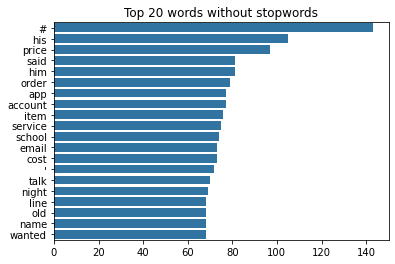

In [560]:
sns.barplot(y=list(lt2_top_20.index), x=lt2_top_20.values, orient='h', color='tab:blue')
plt.title("Top 20 words without stopwords");

In [459]:
lt3 = CountVectorizer(tokenizer=LemmaTokenizer(), min_df=1, max_df=.01)
lt3

CountVectorizer(max_df=0.01,
                tokenizer=<__main__.LemmaTokenizer object at 0x000001871608B8B0>)

In [460]:
X_train_lt3 = pd.DataFrame(lt3.fit_transform(X_train).A, columns=lt3.get_feature_names_out())
X_test_lt3 = pd.DataFrame(lt3.transform(X_test).A, columns=lt3.get_feature_names_out())
X_train_lt3.head(5)

,'actually,'advice,'alpha,'am,'auto,'bad,'blah,'bulking,'but,'cause,...,🙏,🙏❤️,🛑,🤒,🤮,🥑,🥶,🧵,🪖,🪡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [461]:
print(X_train_lt3.shape, X_test_lt3.shape)

(1857, 10926) (619, 10926)


In [462]:
X_train_lt3.shape[1] - X_train_cvec.shape[1]

-1447

No difference in columns.

In [463]:
lt3_top_20 = X_train_lt3.sum().sort_values(ascending=False)[:20]
lt3_top_20

+           63
debt        47
\-          45
delivery    40
ctrl        38
sheet       38
–           37
data        36
gt          35
period      35
click       35
purchase    34
red         34
toilet      33
housing     33
market      33
speed       32
program     32
fruit       32
gift        32
dtype: int64

In [501]:
lt4 = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=15, max_df=.01)
lt4

TfidfVectorizer(max_df=0.01, min_df=15,
                tokenizer=<__main__.LemmaTokenizer object at 0x00000187136DDFA0>)

In [502]:
X_train_lt4 = pd.DataFrame(lt4.fit_transform(X_train).A, columns=lt4.get_feature_names_out())
X_test_lt4 = pd.DataFrame(lt4.transform(X_test).A, columns=lt4.get_feature_names_out())
X_train_lt4.head(5)

,12,5.,7,accept,active,activity,added,adding,adult,advance,...,washing,wear,wet,white,wife,willing,win,writing,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296352,0.0,0.149678
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [503]:
print(X_train_lt4.shape, X_test_lt4.shape)

(1857, 204) (619, 204)


In [504]:
X_train_lt4.shape[1] - X_train_cvec.shape[1]

-12169

No difference in columns.

In [505]:
lt4_top_20 = X_train_lt4.sum().sort_values(ascending=False)[:20]
lt4_top_20

pop         13.119122
exact       12.700149
amazon      12.368954
toilet      12.288400
click       12.133412
tomorrow    11.990057
speed       11.955813
heat        11.787918
news        11.752019
apple       11.726121
delivery    11.557661
tiny        11.540897
salt        11.527239
win         11.509013
language    11.464348
double      11.435123
black       11.321657
fill        11.089262
wake        11.079980
sitting     11.064942
dtype: float64

### Baseline Model

Let's create a baseline model to compare our results.

In [8]:
dc = DummyClassifier()

In [9]:
make_model(dc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7587506731287023
        Test Accuracy Score: 0.7592891760904685
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.0
        Specificity: 1.0
        Precision: 0.0
        
        Balance Accuracy: 0.5
        F1 Score: 0.0
        


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Regarding accuracy, 75.9% of our predictions correctly predicted if a posts belongs to `r/LifeProTips` or `r/lifehacks`.

- Regarding recall, the proportion of correctly predicted `r/lifehacks` posts over actual `r/lifehacks` posts. <br />
In this case we did not correctly predict any posts belong to `r/lifehacks`.

- Regarding specificity, the proportion of correctly predicted `r/LifeProTips` posts over actual `r/LifeProTips` posts. <br />
In this case we correctly predicted all `r/LifeProTips` posts that belong to `r/LifeProTips`.

- Regarding precision, the proportion of correct `r/lifehacks` predictions over all `r/lifehacks` predictions. <br />
Since we did not predict any post to belong to `r/lifehacks`, our precision score cannot be calculated (can't divide by zero). Defaults to zero instead.

- Our balanced accuracy score is the average of our recall and specificty score. It's important for us here because our data is imbalanced (far more cases of `r/LifeProTips` than `r/lifehacks`). <br />
Here we can see that our model is not doing a good job of predicting both classes correctly.

Given that our recall score is `0`, and our specifity score is `1`, our baseline model simply predicted all posts in the dataset to belong to `r/LifeProTips`! <br />
That means we incorrectly predicted about `30%` of our data, hence our accuracy score of 0.759.

F1 score....

### Logistic Regression

Alias: Kronk

In [10]:
lr = LogisticRegression(max_iter=1_000, random_state=14)

In [11]:
make_model(lr, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7366720516962844
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.35570469798657717
        Specificity: 0.8574468085106383
        Precision: 0.44166666666666665
        
        Balance Accuracy: 0.6065757532486077
        F1 Score: 0.3940520446096654
        


Verdict: Worse than our baseline in terms of accuracy.

In [12]:
kronk_coefs = pd.DataFrame(lr.coef_[0], index=X_train_cvec.columns)
kronk_coefs.sort_values(by=0, ascending=False)

,0
hack,1.316535
tried,1.203418
tips,1.167859
oil,0.963483
any,0.821774
...,...
people,-0.749673
money,-0.827517
often,-0.844439
many,-0.859666


Higher scores correlate with `r/lifehack` and lower scores correlate with `r/LifeProTips`.

#### Kronk v2.0

In [13]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 14,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
lr_gs = GridSearchCV(
    LogisticRegression(max_iter=1_000, random_state=14),
    param_grid={
        'C': [1, 5, 10]
    },
    n_jobs=-1
)
lr_gs

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=14),
             n_jobs=-1, param_grid={'C': [1, 5, 10]})

In [15]:
make_model(lr_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7366720516962844
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.35570469798657717
        Specificity: 0.8574468085106383
        Precision: 0.44166666666666665
        
        Balance Accuracy: 0.6065757532486077
        F1 Score: 0.3940520446096654
        


In [17]:
lr_gs.best_params_

{'C': 1}

For some reason this is not working on 'saga' solver!!

In [244]:
make_model(lr_gs, X_train_cvec2, X_test_cvec2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9919224555735057
        Test Accuracy Score: 0.752827140549273
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.3221476510067114
        Specificity: 0.8893617021276595
        Precision: 0.48
        
        Balance Accuracy: 0.6057546765671855
        F1 Score: 0.38554216867469876
        


In [245]:
make_model(lr_gs, X_train_cvec3, X_test_cvec3, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.7657512116316639
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.0738255033557047
        Specificity: 0.9851063829787234
        Precision: 0.6111111111111112
        
        Balance Accuracy: 0.5294659431672141
        F1 Score: 0.1317365269461078
        


In [246]:
make_model(lr_gs, X_train_cvec4, X_test_cvec4, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9859989229940764
        Test Accuracy Score: 0.752827140549273
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.31543624161073824
        Specificity: 0.8914893617021277
        Precision: 0.47959183673469385
        
        Balance Accuracy: 0.603462801656433
        F1 Score: 0.38056680161943324
        


In [465]:
make_model(lr_gs, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9633817985998923
        Test Accuracy Score: 0.7657512116316639
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.3691275167785235
        Specificity: 0.8914893617021277
        Precision: 0.5188679245283019
        
        Balance Accuracy: 0.6303084392403255
        F1 Score: 0.43137254901960786
        


In [507]:
make_model(lr_gs, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9633817985998923
        Test Accuracy Score: 0.7657512116316639
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.3691275167785235
        Specificity: 0.8914893617021277
        Precision: 0.5188679245283019
        
        Balance Accuracy: 0.6303084392403255
        F1 Score: 0.43137254901960786
        


## WINNNER

In [527]:
lr_gs2 = GridSearchCV(
    LogisticRegression(max_iter=1_000, random_state=14),
    param_grid={
        'C': [1, 5, 10],
        'class_weight': [None, 'balanced']
    },
    scoring='recall', #'f1',
    n_jobs=-1
)
lr_gs2

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=14),
             n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'class_weight': [None, 'balanced']},
             scoring='recall')

In [528]:
make_model(lr_gs2, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9888392857142857
        Test Accuracy Score: 0.47651006711409394
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.47651006711409394
        Specificity: 0.7957446808510639
        Precision: 0.4251497005988024
        
        Balance Accuracy: 0.6361273739825789
        F1 Score: 0.44936708860759494
        


In [529]:
lr_gs2.best_params_

{'C': 1, 'class_weight': 'balanced'}

In [543]:
kronk_coefs2 = pd.DataFrame(lr_gs2.best_estimator_.coef_[0], index=X_train_lt2.columns)
top_kronk_coefs = kronk_coefs2.sort_values(by=0, ascending=False)
top_kronk_coefs[:10]

,0
hack,2.209486
plug,1.511174
auto=webp,1.398988
hiccup,1.287466
slide,1.237272
reminder,1.203358
idk,1.191087
glove,1.159934
fly,1.139974
pop,1.136626


In [551]:
list(top_kronk_coefs.index)[:10]

['hack',
 'plug',
 'auto=webp',
 'hiccup',
 'slide',
 'reminder',
 'idk',
 'glove',
 'fly',
 'pop']

In [574]:
top_kronk_coefs[0].values[:10]

array([2.20948566, 1.51117434, 1.39898814, 1.28746568, 1.23727211,
       1.20335831, 1.19108661, 1.1599337 , 1.13997376, 1.13662579])

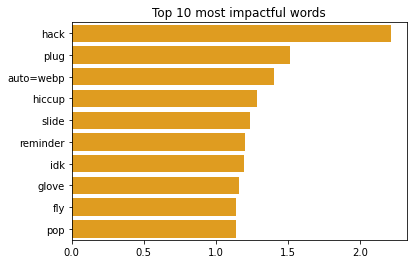

In [580]:
sns.barplot(y=list(top_kronk_coefs.index)[:10], x=top_kronk_coefs[0].values[:10], orient='h', color='orange')
plt.title("Top 10 most impactful words")
#plt.xlabel='Score'
plt.savefig('../images/top_10.png');

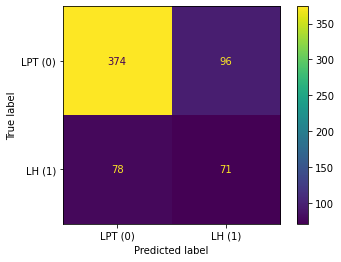

In [586]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(lr_gs2.best_estimator_, X_test_lt2, y_test_encoded, display_labels=['LPT (0)', 'LH (1)'])
#plt.savefig("../images/confusion_matrix.png");

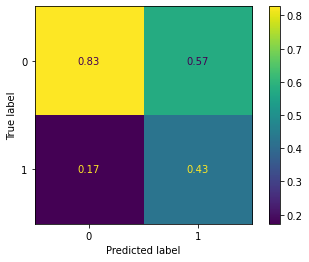

In [532]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(lr_gs2.best_estimator_, X_test_lt2, y_test_encoded, normalize='pred')
#plt.savefig("../images/confusion_matrix.png");

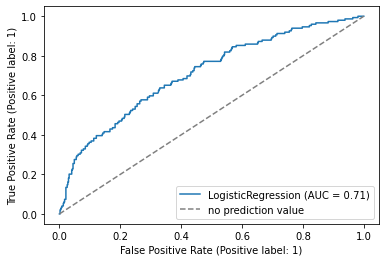

In [535]:
# most current method in scikit-learn is RocCurveDisplay
RocCurveDisplay.from_estimator(lr_gs2.best_estimator_, X_test_lt2, y_test_encoded)

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', linestyle='--', color='gray')

# add a legend
plt.legend()
plt.savefig("../images/roc_curve.png");

-----

In [508]:
lr_gs.best_params_

{'C': 1}

In [486]:
make_model(lr_gs, X_train_lt4, X_test_lt4, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8529886914378029
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.15436241610738255
        Specificity: 0.948936170212766
        Precision: 0.48936170212765956
        
        Balance Accuracy: 0.5516492931600743
        F1 Score: 0.2346938775510204
        


In [506]:
make_model(lr_gs, X_train_lt4, X_test_lt4, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7689822294022617
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.040268456375838924
        Specificity: 0.9851063829787234
        Precision: 0.46153846153846156
        
        Balance Accuracy: 0.5126874196772812
        F1 Score: 0.07407407407407406
        


In [ ]:
lr_gs2 = GridSearchCV(
    LogisticRegression(penalty='l1', max_iter=1_000, random_state=14, solver='saga'),
    param_grid={
        'C': [0.1, 0.5, 1]
    },
    n_jobs=-1
)
lr_gs2

In [ ]:
#make_model(lr_gs2, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)

### K-Nearest-Neighbors

Alisas: Kuzko

In [44]:
knn = KNeighborsClassifier(n_jobs=-1)

In [73]:
make_model(knn, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8056004308023694
        Test Accuracy Score: 0.7221324717285945
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.24161073825503357
        Specificity: 0.874468085106383
        Precision: 0.37894736842105264
        
        Balance Accuracy: 0.5580394116807083
        F1 Score: 0.29508196721311475
        


While the accuracy is better, the recall and precision score went down. This tells us that the model made more correct `r/LifeProTips` predictions, and more incorrect `r/lifehacks`. <br />
Verdict: Worse than Kronk model.

In [30]:
knn_gs = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid={
        'n_neighbors': [20, 25, 30, 35]
    },
    n_jobs=-1
)
knn_gs

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [20, 25, 30, 35]})

In [31]:
make_model(knn_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7587506731287023
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.006711409395973154
        Specificity: 0.9957446808510638
        Precision: 0.3333333333333333
        
        Balance Accuracy: 0.5012280451235185
        F1 Score: 0.013157894736842106
        


In [32]:
knn_gs.best_params_

{'n_neighbors': 30}

### Bagging Classifier

Alias: Yzma

In [59]:
bc = BaggingClassifier(random_state=14, n_jobs=-1)

In [74]:
make_model(bc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.975767366720517
        Test Accuracy Score: 0.7625201938610663
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1476510067114094
        Specificity: 0.9574468085106383
        Precision: 0.5238095238095238
        
        Balance Accuracy: 0.5525489076110239
        F1 Score: 0.23036649214659685
        


Looks like Yzma model is making less predictions of `r/lifehacks`; however, the few that it does predict, it's getting more of those correct, hence why our precision score has increased.
Slight improvement over the Kuzko model.

In [34]:
bc_gs = GridSearchCV(
    BaggingClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators' : [5, 10, 25, 50, 100],
        'bootstrap_features': [False, True]
    },
    n_jobs=-1
)
bc_gs

GridSearchCV(estimator=BaggingClassifier(n_jobs=-1, random_state=14), n_jobs=-1,
             param_grid={'bootstrap_features': [False, True],
                         'n_estimators': [5, 10, 25, 50, 100]})

In [35]:
make_model(bc_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7625201938610663
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1610738255033557
        Specificity: 0.9531914893617022
        Precision: 0.5217391304347826
        
        Balance Accuracy: 0.5571326574325289
        F1 Score: 0.24615384615384617
        


In [36]:
bc_gs.best_params_

{'bootstrap_features': False, 'n_estimators': 50}

### Random Forests

Alias: Pacha

In [77]:
rf = RandomForestClassifier(random_state=14, n_jobs=-1)

In [78]:
make_model(rf, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06711409395973154
        Specificity: 0.9936170212765958
        Precision: 0.7692307692307693
        
        Balance Accuracy: 0.5303655576181636
        F1 Score: 0.12345679012345678
        


Our recall has gone down significantly, which indicates very few predictions for `r/lifehacks` were made. The few predictions that were made about `r/lifehacks` were mostly correct, which is why we have a relatively high precision score.

Making few predictoins for `r/lifehacks` is not ideal for us. Does not outperform Yzma model.

In [38]:
rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 3, 5]
    },
    n_jobs=-1
)
rf_gs

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=14),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [39]:
make_model(rf_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06711409395973154
        Specificity: 0.9936170212765958
        Precision: 0.7692307692307693
        
        Balance Accuracy: 0.5303655576181636
        F1 Score: 0.12345679012345678
        


In [40]:
rf_gs.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

In [60]:
pd.DataFrame(rf_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
hack,0.007384
you,0.006622
tried,0.004729
to,0.004566
https,0.004552
...,...
couldnt,0.000000
offhand,0.000000
counselors,0.000000
offensive,0.000000


### Extra Trees

Alias: Chaca

In [81]:
et = ExtraTreesClassifier(random_state=14, n_jobs=-1)

In [82]:
make_model(et, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.778675282714055
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.12080536912751678
        Specificity: 0.9872340425531915
        Precision: 0.75
        
        Balance Accuracy: 0.5540197058403541
        F1 Score: 0.20809248554913296
        


Higher recall score than Pacha model (makes more `r/lifehacks` predictions) while maintaining essentially the same precision score (same correct/incorrect ratio predictions of `r/lifehacks`). This is a slight imporovement of the Pacha and Yzma model. 

In [41]:
et_gs = GridSearchCV(
    ExtraTreesClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 3, 5]
    },
    n_jobs=-1
)
et_gs

GridSearchCV(estimator=ExtraTreesClassifier(n_jobs=-1, random_state=14),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [42]:
make_model(et_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.778675282714055
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.12080536912751678
        Specificity: 0.9872340425531915
        Precision: 0.75
        
        Balance Accuracy: 0.5540197058403541
        F1 Score: 0.20809248554913296
        


In [61]:
pd.DataFrame(et_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
hack,0.008882
hacks,0.005128
tried,0.004048
tips,0.003809
you,0.003743
...,...
cosmic,0.000000
costco,0.000000
costing,0.000000
proxy,0.000000


### Ada Boost Classifier

Alias: Tipo

In [85]:
abc = AdaBoostClassifier(random_state=14)

In [86]:
make_model(abc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8136779752288638
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.28859060402684567
        Specificity: 0.9063829787234042
        Precision: 0.4942528735632184
        
        Balance Accuracy: 0.597486791375125
        F1 Score: 0.3644067796610169
        


It appears more predictions were made for `r/lifehacks` (higher recall score) but the amount of correct predictions went down (lower precision score). Our F1 score is only second to the Kronk model.

In [44]:
abc_gs = GridSearchCV(
    AdaBoostClassifier(random_state=14),
    param_grid={
        'n_estimators': [100, 150, 200, 250]
    },
    n_jobs=-1
)
abc_gs

GridSearchCV(estimator=AdaBoostClassifier(random_state=14), n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250]})

In [45]:
make_model(abc_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8933764135702746
        Test Accuracy Score: 0.7447495961227787
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.30201342281879195
        Specificity: 0.8851063829787233
        Precision: 0.45454545454545453
        
        Balance Accuracy: 0.5935599028987577
        F1 Score: 0.3629032258064516
        


In [46]:
abc_gs.best_params_

{'n_estimators': 150}

In [62]:
pd.DataFrame(abc_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
at,0.020000
often,0.013333
tips,0.013333
time,0.013333
be,0.013333
...,...
eyeball,0.000000
eyebrow,0.000000
eyeglasses,0.000000
eyeing,0.000000


In [357]:
make_model(abc_gs, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8551427032848681
        Test Accuracy Score: 0.7560581583198708
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.28859060402684567
        Specificity: 0.9042553191489362
        Precision: 0.48863636363636365
        
        Balance Accuracy: 0.5964229615878909
        F1 Score: 0.3628691983122363
        


-----

Now that we have found the best estimators in our gridsearches, let's ensemble all our models for the best possible classifications.

In [238]:
vr = VotingClassifier(
    [
        ('lr_vr', lr_gs.best_estimator_),
        ('knn_vr', knn_gs.best_estimator_),
        ('bc_vr', bc_gs.best_estimator_),
        ('rf_vr', rf_gs.best_estimator_),
        ('et_vr', et_gs.best_estimator_),
        ('abc_vr', abc_gs.best_estimator_)
    ],
    n_jobs=-1,
)
vr

VotingClassifier(estimators=[('lr_vr',
                              LogisticRegression(C=1, max_iter=1000,
                                                 random_state=14)),
                             ('knn_vr',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=30)),
                             ('bc_vr',
                              BaggingClassifier(n_estimators=50, n_jobs=-1,
                                                random_state=14)),
                             ('rf_vr',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=14)),
                             ('et_vr',
                              ExtraTreesClassifier(n_jobs=-1, random_state=14)),
                             ('abc_vr',
                              AdaBoostClassifier(n_estimators=150,
                                                 random_state=14))],
                 n_jobs=-1)

In [241]:
make_model(vr, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9967689822294022
        Test Accuracy Score: 0.777059773828756
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.10067114093959731
        Specificity: 0.9914893617021276
        Precision: 0.7894736842105263
        
        Balance Accuracy: 0.5460802513208625
        F1 Score: 0.17857142857142858
        


In [240]:
make_model(vr, X_train_cvec2, X_test_cvec2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9913839526117394
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1342281879194631
        Specificity: 0.9723404255319149
        Precision: 0.6060606060606061
        
        Balance Accuracy: 0.553284306725689
        F1 Score: 0.21978021978021978
        


In [242]:
make_model(vr, X_train_cvec3, X_test_cvec3, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9924609585352719
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06040268456375839
        Specificity: 0.9957446808510638
        Precision: 0.8181818181818182
        
        Balance Accuracy: 0.5280736827074111
        F1 Score: 0.1125
        


In [243]:
make_model(vr, X_train_cvec4, X_test_cvec4, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9859989229940764
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.18120805369127516
        Specificity: 0.9574468085106383
        Precision: 0.574468085106383
        
        Balance Accuracy: 0.5693274311009567
        F1 Score: 0.2755102040816327
        


-----

In [514]:
vr2 = VotingClassifier(
    [
        ('lr2_vr', lr_gs2.best_estimator_),
        ('rf_vr', rf_gs.best_estimator_),
        ('abc_vr', abc_gs.best_estimator_)
    ],
    n_jobs=-1
)
vr2

VotingClassifier(estimators=[('lr2_vr',
                              LogisticRegression(C=1, class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=14)),
                             ('rf_vr',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=14)),
                             ('abc_vr',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=14))],
                 n_jobs=-1)

In [260]:
make_model(vr, X_train_tf, X_test_tf, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9477652127086699
        Test Accuracy Score: 0.7722132471728594
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.087248322147651
        Specificity: 0.9893617021276596
        Precision: 0.7222222222222222
        
        Balance Accuracy: 0.5383050121376554
        F1 Score: 0.15568862275449102
        


In [268]:
make_model(vr, X_train_tf2, X_test_tf2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.946149703823371
        Test Accuracy Score: 0.7689822294022617
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.087248322147651
        Specificity: 0.9851063829787234
        Precision: 0.65
        
        Balance Accuracy: 0.5361773525631872
        F1 Score: 0.15384615384615385
        


In [274]:
make_model(vr, X_train_tf3, X_test_tf3, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9407646742057081
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.12751677852348994
        Specificity: 0.9744680851063829
        Precision: 0.6129032258064516
        
        Balance Accuracy: 0.5509924318149364
        F1 Score: 0.21111111111111114
        


In [286]:
make_model(vr, X_train_tf4, X_test_tf4, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.929456112008616
        Test Accuracy Score: 0.7689822294022617
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.14093959731543623
        Specificity: 0.9680851063829787
        Precision: 0.5833333333333334
        
        Balance Accuracy: 0.5545123518492074
        F1 Score: 0.22702702702702704
        


In [302]:
make_model(vr, X_train_tf5, X_test_tf5, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9116855142703285
        Test Accuracy Score: 0.7560581583198708
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06711409395973154
        Specificity: 0.9744680851063829
        Precision: 0.45454545454545453
        
        Balance Accuracy: 0.5207910895330572
        F1 Score: 0.11695906432748539
        


-----

In [355]:
make_model(vr, X_train_lt, X_test_lt, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.996230479267636
        Test Accuracy Score: 0.7657512116316639
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.053691275167785234
        Specificity: 0.9914893617021276
        Precision: 0.6666666666666666
        
        Balance Accuracy: 0.5225903184349564
        F1 Score: 0.09937888198757763
        


In [369]:
make_model(vr, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.96661281637049
        Test Accuracy Score: 0.778675282714055
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.2348993288590604
        Specificity: 0.951063829787234
        Precision: 0.603448275862069
        
        Balance Accuracy: 0.5929815793231472
        F1 Score: 0.33816425120772947
        


In [363]:
make_model(vr, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9644588045234249
        Test Accuracy Score: 0.7625201938610663
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.24161073825503357
        Specificity: 0.9276595744680851
        Precision: 0.5142857142857142
        
        Balance Accuracy: 0.5846351563615594
        F1 Score: 0.3287671232876712
        


In [464]:
make_model(vr, X_train_lt3, X_test_lt3, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.975767366720517
        Test Accuracy Score: 0.7657512116316639
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1610738255033557
        Specificity: 0.9574468085106383
        Precision: 0.5454545454545454
        
        Balance Accuracy: 0.559260317006997
        F1 Score: 0.24870466321243523
        


In [515]:
make_model(vr2, X_train_lt2, X_test_lt2, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9940764674205708
        Test Accuracy Score: 0.7641357027463651
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.3087248322147651
        Specificity: 0.9085106382978724
        Precision: 0.5168539325842697
        
        Balance Accuracy: 0.6086177352563187
        F1 Score: 0.3865546218487395
        
